## Run MD with vanilla/og system and then check that difference in energies between vanilla vs hybrid system are close to 0

In [1]:
from tqdm import tqdm_notebook
import openmmtools
import matplotlib.pyplot as plt
import pickle

from simtk import openmm
from simtk.openmm import unit
import openmmtools
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache
from openmmtools.constants import kB

from perses.annihilation.lambda_protocol import RESTState, RESTCapableRelativeAlchemicalState, RESTCapableLambdaProtocol
from perses.dispersed import feptasks

import numpy as np

from perses.app.relative_point_mutation_setup import PointMutationExecutor


INFO:rdkit:Enabling RDKit 2021.03.4 jupyter extensions


## Test at lambda = 0

In [2]:
# htf = solvent_delivery.get_apo_htf()
with open("/data/chodera/zhangi/perses_benchmark/repex/32/3/5/5_apo.pickle", "rb") as f:
    htf = pickle.load(f)
hybrid_system = htf.hybrid_system
hybrid_positions = htf.hybrid_positions
box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()


In [3]:
old_system = htf._topology_proposal.old_system
hybrid_system = htf.hybrid_system
for i in range(hybrid_system.getNumParticles()):
    if hybrid_system.getParticleMass(i) != old_system.getParticleMass(i):
        print(i, hybrid_system.getParticleMass(i), old_system.getParticleMass(i))

10 6.026000000000001 Da 3.0340000000000007 Da


OpenMMException: Assertion failure at System.cpp:55.  Index out of range

In [4]:
htf.hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b0d9b884db0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b0d9b884cf0> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b0d9b884cc0> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b0d9b884ba0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b0d9bd7cf00> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b0d9bd7ce10> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b0d9bd7ce40> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b0d9bd7ced0> >]

In [11]:
T_min = 300 * unit.kelvin
T_max = 1200 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
1.0
0.0


In [12]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [13]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [14]:
# Run MD
hybrid = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    hybrid.append(pos)


/scratch/lsftmp/4182622.tmpdir/ipykernel_25105/2861022740.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
# with open("hybrid_positions_atp.pickle", "wb") as f:
#     pickle.dump(hybrid, f)

In [16]:
# with open("hybrid_positions_atp.pickle", "rb") as f:
#     hybrid = pickle.load(f)

In [17]:
# Make context for og system
thermodynamic_state = ThermodynamicState(htf._topology_proposal.old_system, temperature=T_min)
integrator_og = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_og = thermodynamic_state.create_context(integrator_og)


# Zero the unique old/new valence in the hybrid system
bond_force_index = 1 
angle_force_index = 2 
torsion_force_index = 3 
custom_bond_force = hybrid_system.getForce(bond_force_index)
custom_angle_force = hybrid_system.getForce(angle_force_index)
custom_torsion_force = hybrid_system.getForce(torsion_force_index)
is_old = True
hybrid_to_bond_indices = htf._hybrid_to_new_bond_indices if is_old else htf._hybrid_to_old_bond_indices
hybrid_to_angle_indices = htf._hybrid_to_new_angle_indices if is_old else htf._hybrid_to_old_angle_indices
hybrid_to_torsion_indices = htf._hybrid_to_new_torsion_indices if is_old else htf._hybrid_to_old_torsion_indices
for hybrid_idx, idx in hybrid_to_bond_indices.items():
    p1, p2, hybrid_params = custom_bond_force.getBondParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-2] *= 0 # zero K_old
    hybrid_params[-1] *= 0 # zero K_new
    custom_bond_force.setBondParameters(hybrid_idx, p1, p2, hybrid_params)
for hybrid_idx, idx in hybrid_to_angle_indices.items():
    p1, p2, p3, hybrid_params = custom_angle_force.getAngleParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_angle_force.setAngleParameters(hybrid_idx, p1, p2, p3, hybrid_params)
for hybrid_idx, idx in hybrid_to_torsion_indices.items():
    p1, p2, p3, p4, hybrid_params = custom_torsion_force.getTorsionParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_torsion_force.setTorsionParameters(hybrid_idx, p1, p2, p3, p4, hybrid_params)

# Make context for hybrid system
T_min = 300 * unit.kelvin
T_max = 1200 * unit.kelvin

lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

integrator_hybrid = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_hybrid = compound_thermodynamic_state.create_context(integrator_hybrid)

# Get energies for each conformation
energies_og = list()
energies_hybrid = list()
for pos in tqdm_notebook(hybrid):
   
    context_og.setPositions(htf.old_positions(pos))
    energy_og = context_og.getState(getEnergy=True).getPotentialEnergy()
    energies_og.append(energy_og.value_in_unit_system(unit.md_unit_system))
    
    context_hybrid.setPositions(pos)
    energy_hybrid = context_hybrid.getState(getEnergy=True).getPotentialEnergy()
    energies_hybrid.append(energy_hybrid.value_in_unit_system(unit.md_unit_system))
    
    print(energy_og, energy_hybrid)

/scratch/lsftmp/4182622.tmpdir/ipykernel_25105/461518790.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pos in tqdm_notebook(hybrid):


  0%|          | 0/500 [00:00<?, ?it/s]

-22569.871949555454 kJ/mol -22569.884303386738 kJ/mol
-22057.473512055454 kJ/mol -22057.489772136738 kJ/mol
-21460.496949555454 kJ/mol -21460.505397136738 kJ/mol
-21035.809449555454 kJ/mol -21035.825709636738 kJ/mol
-20702.450074555454 kJ/mol -20702.458522136738 kJ/mol
-20547.090699555454 kJ/mol -20547.105006511738 kJ/mol
-20499.950074555454 kJ/mol -20499.958522136738 kJ/mol
-20746.371949555454 kJ/mol -20746.378444011738 kJ/mol
-20483.700074555454 kJ/mol -20483.708522136738 kJ/mol
-20357.606324555454 kJ/mol -20357.622584636738 kJ/mol
-20191.879762055454 kJ/mol -20191.896022136738 kJ/mol
-20117.668824555454 kJ/mol -20117.687037761738 kJ/mol
-20116.246949555454 kJ/mol -20116.257350261738 kJ/mol
-20153.817262055454 kJ/mol -20153.829615886738 kJ/mol
-20149.012574555454 kJ/mol -20149.019069011738 kJ/mol
-20070.731324555454 kJ/mol -20070.739772136738 kJ/mol
-19844.770387055454 kJ/mol -19844.782740886738 kJ/mol
-20043.653199555454 kJ/mol -20043.661647136738 kJ/mol
-20379.621949555454 kJ/mol -

-19730.075074555454 kJ/mol -19730.085475261738 kJ/mol
-19988.411012055454 kJ/mol -19988.425319011738 kJ/mol
-19895.356324555454 kJ/mol -19895.364772136738 kJ/mol
-20126.778199555454 kJ/mol -20126.794459636738 kJ/mol
-20124.614137055454 kJ/mol -20124.626490886738 kJ/mol
-19875.012574555454 kJ/mol -19875.019069011738 kJ/mol
-19880.465699555454 kJ/mol -19880.485865886738 kJ/mol
-20339.262574555454 kJ/mol -20339.278834636738 kJ/mol
-20441.520387055454 kJ/mol -20441.532740886738 kJ/mol
-20503.434449555454 kJ/mol -20503.444850261738 kJ/mol
-20148.028199555454 kJ/mol -20148.042506511738 kJ/mol
-20301.090699555454 kJ/mol -20301.101100261738 kJ/mol
-20334.098512055454 kJ/mol -20334.106959636738 kJ/mol
-20406.278199555454 kJ/mol -20406.290553386738 kJ/mol
-20362.871949555454 kJ/mol -20362.884303386738 kJ/mol
-20276.481324555454 kJ/mol -20276.489772136738 kJ/mol
-20406.129762055454 kJ/mol -20406.134303386738 kJ/mol
-20304.817262055454 kJ/mol -20304.829615886738 kJ/mol
-20426.332887055454 kJ/mol -

-19865.278199555454 kJ/mol -19865.292506511738 kJ/mol
-20239.996949555454 kJ/mol -20240.013209636738 kJ/mol
-20045.028199555454 kJ/mol -20045.042506511738 kJ/mol
-20461.153199555454 kJ/mol -20461.161647136738 kJ/mol
-20480.918824555454 kJ/mol -20480.927272136738 kJ/mol
-20277.465699555454 kJ/mol -20277.481959636738 kJ/mol
-20323.004762055454 kJ/mol -20323.013209636738 kJ/mol
-20650.317262055454 kJ/mol -20650.329615886738 kJ/mol
-20567.114137055454 kJ/mol -20567.124537761738 kJ/mol
-20599.817262055454 kJ/mol -20599.831569011738 kJ/mol
-20567.395387055454 kJ/mol -20567.411647136738 kJ/mol
-20591.637574555454 kJ/mol -20591.649928386738 kJ/mol
-20245.207887055454 kJ/mol -20245.224147136738 kJ/mol
-20249.387574555454 kJ/mol -20249.405787761738 kJ/mol
-20053.200074555454 kJ/mol -20053.218287761738 kJ/mol
-19886.059449555454 kJ/mol -19886.071803386738 kJ/mol
-19761.176637055454 kJ/mol -19761.188990886738 kJ/mol
-19783.973512055454 kJ/mol -19783.981959636738 kJ/mol
-20069.246949555454 kJ/mol -

-19984.879762055454 kJ/mol -19984.896022136738 kJ/mol
-19995.481324555454 kJ/mol -19995.501490886738 kJ/mol
-20210.575074555454 kJ/mol -20210.585475261738 kJ/mol
-20328.036012055454 kJ/mol -20328.052272136738 kJ/mol
-20370.387574555454 kJ/mol -20370.396022136738 kJ/mol
-20479.856324555454 kJ/mol -20479.864772136738 kJ/mol
-20312.450074555454 kJ/mol -20312.466334636738 kJ/mol
-20204.200074555454 kJ/mol -20204.216334636738 kJ/mol
-20456.762574555454 kJ/mol -20456.774928386738 kJ/mol
-20260.871949555454 kJ/mol -20260.894069011738 kJ/mol
-20412.426637055454 kJ/mol -20412.438990886738 kJ/mol
-20289.887574555454 kJ/mol -20289.907740886738 kJ/mol
-20505.762574555454 kJ/mol -20505.776881511738 kJ/mol
-20180.434449555454 kJ/mol -20180.458522136738 kJ/mol
-20115.270387055454 kJ/mol -20115.278834636738 kJ/mol
-20213.864137055454 kJ/mol -20213.876490886738 kJ/mol
-20409.996949555454 kJ/mol -20410.007350261738 kJ/mol
-20364.528199555454 kJ/mol -20364.536647136738 kJ/mol
-20568.684449555454 kJ/mol -

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

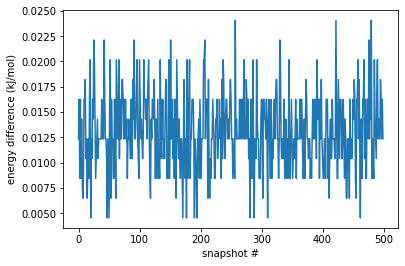

In [18]:
plt.plot(np.array(energies_og) - np.array(energies_hybrid))
plt.ylabel("energy difference (kJ/mol)")
plt.xlabel("snapshot #")
plt.show()

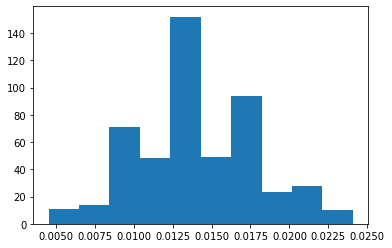

In [19]:
plt.hist(np.array(energies_og) - np.array(energies_hybrid))
plt.show()

In [15]:
# with open("energies_atp_hybrid.pickle", "wb") as f:
#     pickle.dump(energies_hybrid, f)
# with open("energies_atp_og.pickle", "wb") as f:
#     pickle.dump(energies_og, f)

## Test at lambda = 1

In [18]:
# htf = solvent_delivery.get_apo_htf()
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
hybrid_system = htf.hybrid_system
hybrid_positions = htf.hybrid_positions
box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()


In [19]:
htf.hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b4ddfe795a0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b4ddfe79360> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b4ddfe79570> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b4df3a25ed0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b4df3a25d50> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b4df3a25cf0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b4df3a25c30> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b4df3a25cc0> >]

In [20]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
0.0
1.0


In [21]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [22]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [23]:
# Run MD
hybrid = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    hybrid.append(pos)


/scratch/lsftmp/4086171.tmpdir/ipykernel_60976/2861022740.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
with open("hybrid_positions_atp_lambda_1.pickle", "wb") as f:
    pickle.dump(hybrid, f)

In [25]:
with open("hybrid_positions_atp_lambda_1.pickle", "rb") as f:
    hybrid = pickle.load(f)

In [31]:
# Make context for og system
thermodynamic_state = ThermodynamicState(htf._topology_proposal.new_system, temperature=T_min)
integrator_og = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_og = thermodynamic_state.create_context(integrator_og)


# Zero the unique old/new valence in the hybrid system
bond_force_index = 1 
angle_force_index = 2 
torsion_force_index = 3 
custom_bond_force = hybrid_system.getForce(bond_force_index)
custom_angle_force = hybrid_system.getForce(angle_force_index)
custom_torsion_force = hybrid_system.getForce(torsion_force_index)
is_old = False
hybrid_to_bond_indices = htf._hybrid_to_new_bond_indices if is_old else htf._hybrid_to_old_bond_indices
hybrid_to_angle_indices = htf._hybrid_to_new_angle_indices if is_old else htf._hybrid_to_old_angle_indices
hybrid_to_torsion_indices = htf._hybrid_to_new_torsion_indices if is_old else htf._hybrid_to_old_torsion_indices
for hybrid_idx, idx in hybrid_to_bond_indices.items():
    p1, p2, hybrid_params = custom_bond_force.getBondParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-2] *= 0 # zero K_old
    hybrid_params[-1] *= 0 # zero K_new
    custom_bond_force.setBondParameters(hybrid_idx, p1, p2, hybrid_params)
for hybrid_idx, idx in hybrid_to_angle_indices.items():
    p1, p2, p3, hybrid_params = custom_angle_force.getAngleParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_angle_force.setAngleParameters(hybrid_idx, p1, p2, p3, hybrid_params)
for hybrid_idx, idx in hybrid_to_torsion_indices.items():
    p1, p2, p3, p4, hybrid_params = custom_torsion_force.getTorsionParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_torsion_force.setTorsionParameters(hybrid_idx, p1, p2, p3, p4, hybrid_params)

# Make context for hybrid system
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

integrator_hybrid = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_hybrid = compound_thermodynamic_state.create_context(integrator_hybrid)

# Get energies for each conformation
energies_og = list()
energies_hybrid = list()
for pos in tqdm_notebook(hybrid):
   
    context_og.setPositions(htf.new_positions(pos))
    energy_og = context_og.getState(getEnergy=True).getPotentialEnergy()
    energies_og.append(energy_og.value_in_unit_system(unit.md_unit_system))
    
    context_hybrid.setPositions(pos)
    energy_hybrid = context_hybrid.getState(getEnergy=True).getPotentialEnergy()
    energies_hybrid.append(energy_hybrid.value_in_unit_system(unit.md_unit_system))
    
    print(energy_og, energy_hybrid)

/scratch/lsftmp/4086171.tmpdir/ipykernel_60976/982440890.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pos in tqdm_notebook(hybrid):


  0%|          | 0/500 [00:00<?, ?it/s]

-22763.57245017565 kJ/mol -22763.579143530827 kJ/mol
-21645.00213767565 kJ/mol -21645.014690405827 kJ/mol
-21327.02557517565 kJ/mol -21327.032268530827 kJ/mol
-21251.38495017565 kJ/mol -21251.391643530827 kJ/mol
-20913.32245017565 kJ/mol -20913.331096655827 kJ/mol
-20740.31463767565 kJ/mol -20740.325237280827 kJ/mol
-20465.09588767565 kJ/mol -20465.110393530827 kJ/mol
-20606.83026267565 kJ/mol -20606.844768530827 kJ/mol
-20404.46307517565 kJ/mol -20404.473674780827 kJ/mol
-19980.40057517565 kJ/mol -19980.418987280827 kJ/mol
-20583.74432517565 kJ/mol -20583.754924780827 kJ/mol
-20265.11932517565 kJ/mol -20265.129924780827 kJ/mol
-20562.10370017565 kJ/mol -20562.114299780827 kJ/mol
-20227.16620017565 kJ/mol -20227.174846655827 kJ/mol
-20413.13495017565 kJ/mol -20413.153362280827 kJ/mol
-20484.52557517565 kJ/mol -20484.543987280827 kJ/mol
-20571.11151267565 kJ/mol -20571.126018530827 kJ/mol
-20655.19745017565 kJ/mol -20655.210002905827 kJ/mol
-20352.67401267565 kJ/mol -20352.682659155827 

-20203.60370017565 kJ/mol -20203.614299780827 kJ/mol
-20584.24432517565 kJ/mol -20584.258831030827 kJ/mol
-20617.24432517565 kJ/mol -20617.258831030827 kJ/mol
-20631.67401267565 kJ/mol -20631.688518530827 kJ/mol
-20576.22870017565 kJ/mol -20576.243206030827 kJ/mol
-20606.60370017565 kJ/mol -20606.618206030827 kJ/mol
-20881.65057517565 kJ/mol -20881.665081030827 kJ/mol
-20758.24432517565 kJ/mol -20758.254924780827 kJ/mol
-20420.61151267565 kJ/mol -20420.626018530827 kJ/mol
-20638.80682517565 kJ/mol -20638.821331030827 kJ/mol
-20858.65838767565 kJ/mol -20858.676799780827 kJ/mol
-21000.26776267565 kJ/mol -21000.282268530827 kJ/mol
-21023.89276267565 kJ/mol -21023.903362280827 kJ/mol
-20793.97088767565 kJ/mol -20793.985393530827 kJ/mol
-20769.41620017565 kJ/mol -20769.430706030827 kJ/mol
-20771.20526267565 kJ/mol -20771.223674780827 kJ/mol
-20970.19745017565 kJ/mol -20970.211956030827 kJ/mol
-20543.24432517565 kJ/mol -20543.258831030827 kJ/mol
-20713.93963767565 kJ/mol -20713.954143530827 

-20563.26776267565 kJ/mol -20563.278362280827 kJ/mol
-20485.33807517565 kJ/mol -20485.348674780827 kJ/mol
-20508.10370017565 kJ/mol -20508.118206030827 kJ/mol
-20288.22870017565 kJ/mol -20288.239299780827 kJ/mol
-20014.75995017565 kJ/mol -20014.766643530827 kJ/mol
-19859.68182517565 kJ/mol -19859.700237280827 kJ/mol
-20015.06463767565 kJ/mol -20015.075237280827 kJ/mol
-20180.78338767565 kJ/mol -20180.795940405827 kJ/mol
-20246.75995017565 kJ/mol -20246.774456030827 kJ/mol
-20086.21307517565 kJ/mol -20086.227581030827 kJ/mol
-19505.30682517565 kJ/mol -19505.317424780827 kJ/mol
-20013.21307517565 kJ/mol -20013.217815405827 kJ/mol
-20304.69745017565 kJ/mol -20304.711956030827 kJ/mol
-20300.12713767565 kJ/mol -20300.137737280827 kJ/mol
-20432.08807517565 kJ/mol -20432.098674780827 kJ/mol
-20186.74432517565 kJ/mol -20186.756877905827 kJ/mol
-19673.69745017565 kJ/mol -19673.715862280827 kJ/mol
-20163.88495017565 kJ/mol -20163.891643530827 kJ/mol
-20303.43182517565 kJ/mol -20303.438518530827 

-20424.43182517565 kJ/mol -20424.448284155827 kJ/mol
-20465.97870017565 kJ/mol -20465.997112280827 kJ/mol
-20316.71307517565 kJ/mol -20316.721721655827 kJ/mol
-20247.90057517565 kJ/mol -20247.918987280827 kJ/mol
-20303.05682517565 kJ/mol -20303.071331030827 kJ/mol
-20436.83807517565 kJ/mol -20436.860393530827 kJ/mol
-20498.19745017565 kJ/mol -20498.208049780827 kJ/mol
-20521.76776267565 kJ/mol -20521.782268530827 kJ/mol
-20893.83026267565 kJ/mol -20893.844768530827 kJ/mol
-20618.07245017565 kJ/mol -20618.092815405827 kJ/mol
-20568.04901267565 kJ/mol -20568.063518530827 kJ/mol
-20204.59588767565 kJ/mol -20204.610393530827 kJ/mol
-20065.02557517565 kJ/mol -20065.040081030827 kJ/mol
-20331.03338767565 kJ/mol -20331.045940405827 kJ/mol
-20325.18963767565 kJ/mol -20325.206096655827 kJ/mol
-20271.32245017565 kJ/mol -20271.325237280827 kJ/mol
-20505.38495017565 kJ/mol -20505.403362280827 kJ/mol
-20828.99432517565 kJ/mol -20829.004924780827 kJ/mol
-20707.08807517565 kJ/mol -20707.104534155827 

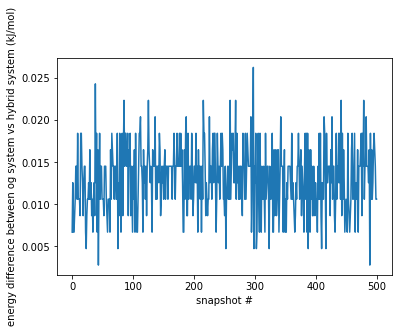

In [32]:
plt.plot(np.array(energies_og) - np.array(energies_hybrid))
plt.ylabel("energy difference between og system vs hybrid system (kJ/mol)")
plt.xlabel("snapshot #")
plt.show()

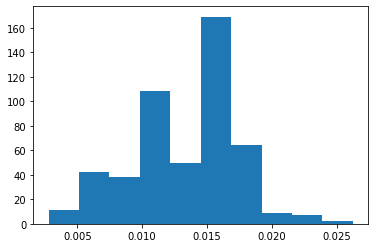

In [33]:
plt.hist(np.array(energies_og) - np.array(energies_hybrid))
plt.show()

In [34]:
with open("energies_atp_hybrid_lambda_1.pickle", "wb") as f:
    pickle.dump(energies_hybrid, f)
with open("energies_atp_og_lambda_1.pickle", "wb") as f:
    pickle.dump(energies_og, f)